In [1]:
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.morphology import dilation, square
from skimage.restoration import denoise_tv_chambolle
from skimage.measure import regionprops
from torch.utils.data import Dataset
import torchvision.transforms.functional as F

from pydicom import dcmread
from pydicom.encaps import encapsulate
from pydicom.pixel_data_handlers.util import apply_modality_lut

import os
from tqdm.notebook import tqdm

%matplotlib widget

from utils.function_lib import *

from FusionSystem.FusionNetwork import FusionNetwork

In [2]:
transform_ct = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BILINEAR, antialias=True),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.2], std=[0.2])
     ])

transform_liver = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BILINEAR, antialias=True),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])
     ])

resize_trans = transforms.Compose([
    transforms.Resize(512, transforms.InterpolationMode.BILINEAR, antialias=True)
])

## Incarcam modelul

In [3]:
device = torch.device('cpu')

model = FusionNetwork('G:/MachineLearning/models/')
model_lesion = FusionNetwork('G:/MachineLearning/models-lesion/')

model.to(device)
model_lesion.to(device)

model.eval()
model_lesion.eval()
print("Done loading models")

Done loading models


## Folderele de lucru

In [4]:
load_path = 'G:/MachineLearning/DICOM_Database/demo/venos/'
out_path = 'G:/MachineLearning/DICOM_Database/demo/venos segmentat/'
if not os.path.exists(out_path):
    os.makedirs(out_path)

dicom_files = glob.glob(load_path + 'image_*')

## Ceva parametri de lucru

In [5]:
window_min = -250.0
window_max = 250.0

## Iteram pe rand prin fiecare imagine

In [8]:
for dicom_path in tqdm(dicom_files):
    datastore = dcmread(dicom_path)
    image = datastore.pixel_array
    image = apply_modality_lut(image, datastore)
    image = image.astype(np.float32)

    # Procesarea initiala a imaginii DICOM
    image[image < window_min] = window_min
    image[image > window_max] = window_max
    image = (image - window_min) / (window_max - window_min)

    # Chambolle TV denoising
    image = denoise_tv_chambolle(image, weight=0.02)

    init_image = torch.tensor(image)
    init_size = init_image.shape[0]



    # Generam segmentarea ficatului
    input_tensor = transform_ct(image)
    input_batch = input_tensor.repeat(2, 1, 1, 1)
    input_batch = input_batch.to(device)
    with torch.no_grad():
        output = model(input_batch)[0]

    output = resize_trans(output)
    mask_liver = torch.round(output)

    # Extragem ficatul pe baza mastii
    props = regionprops(mask_liver.numpy().astype(np.int32))
    (minz, minx, miny, maxz, maxx, maxy) = props[0].bbox

    crop_size = max(maxx - minx, maxy - miny) + 5
    crop_center = (int((maxx + minx) / 2), int((maxy + miny) / 2))

    bounds = [max(crop_center[0] - int(crop_size / 2), 0),
              min(crop_center[0] + int(crop_size / 2), image.shape[0]),
              max(crop_center[1] - int(crop_size / 2), 0),
              min(crop_center[1] + int(crop_size / 2), image.shape[1])]

    only_liver = np.copy(image)
    only_liver[mask_liver.detach().numpy().squeeze() == 0] = 0

    liver_image = np.copy(only_liver[bounds[0]:bounds[1], bounds[2]:bounds[3]]) # Taiem doar ce ne intereseaza

    if np.max(liver_image.flatten()) > 0.001:
        mean = np.mean(liver_image[liver_image > 0.0001].flatten())
        liver_image[liver_image < 0.0001] = mean
        liver_image = exposure.equalize_adapthist(liver_image, clip_limit=0.01)

    restore_size = transforms.Resize(liver_image.shape, interpolation=transforms.functional.InterpolationMode.BILINEAR, antialias=True)

    liver_tensor = transform_liver(liver_image)
    input_batch = liver_tensor.repeat(2, 1, 1, 1)
    input_batch = input_batch.to(device)
    with torch.no_grad():
        output = model_lesion(input_batch)[0]


    output = restore_size(output)
    output[output > 0.05] = 1
    output[output < 0.05] = 0

    mask_lesion = np.zeros((512, 512))
    mask_lesion[bounds[0]:bounds[1], bounds[2]:bounds[3]] = output.detach().numpy().squeeze()
    for i in range(5):
        mask_lesion = dilation(mask_lesion)

    mask_lesion = torch.tensor(mask_lesion)

    seg_result = torchvision.utils.draw_segmentation_masks((init_image*255).repeat(3, 1, 1).type(torch.uint8),
                                                    (mask_liver*255).type(torch.bool),
                                                    0.3, "green")

    seg_result = torchvision.utils.draw_segmentation_masks(seg_result,
                                                           (mask_lesion*255).type(torch.bool),
                                                           0.4, "red")

    # Magie cu tag-uri DICOM ca sa arate corect culorile
    datastore.PhotometricInterpretation = 'RGB'
    datastore.SamplesPerPixel = 3
    datastore.BitsAllocated = 8
    datastore.BitsStored = 8
    datastore.HighBit = 7

    datastore.add_new(0x00280006, 'US', 0)
    datastore.is_little_endian = True

    datastore.PixelData = np.flipud(np.moveaxis(seg_result.cpu().numpy(), 0, 2)).tobytes()

    # In final salvam fisierul DICOM cu masca
    save_path = out_path + os.path.basename(dicom_path)
    datastore.fix_meta_info()
    datastore.save_as(save_path)

  0%|          | 0/10 [00:00<?, ?it/s]

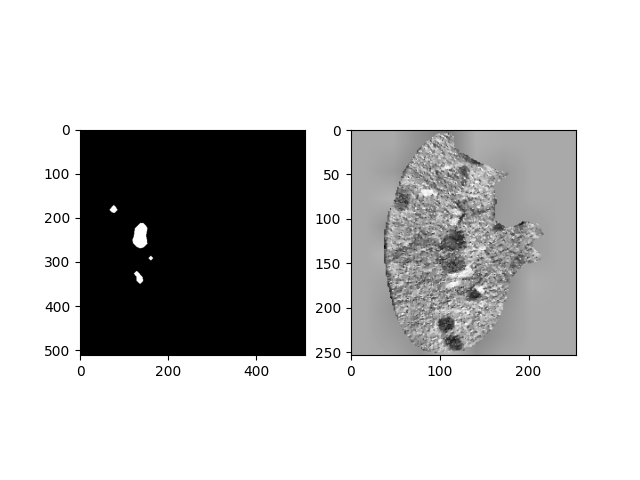

In [9]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(mask_lesion.detach().numpy().squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(liver_image.squeeze(), cmap='gray')